## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import os
from pathlib import Path

In [2]:
path = Path(os.path.abspath(''))
util_path = str(path.parent.absolute())

if util_path not in sys.path:
    sys.path.append(util_path)
    
from utils import helpers

## Import Data

In [4]:
def get_churn_data():
    data = pd.read_csv("../data/raw/telco-churn-data.csv")
    return data

In [ ]:
df_telco = get_churn_data()
df_telco

In [ ]:
df_telco.describe()

In [ ]:
df_telco.info()

In [ ]:
for column in df_telco.columns:
    print('Column: {} - Unique Values: {}'.format(column, df_telco[column].unique()))

## EDA

1. Visualize all the cols
2. Check for outliers
3. Random forest feature importance
4. Check target distribution
5. Check for missing values

In [5]:
# Pre-processing with method chaining

df = (
    get_churn_data()
    .assign(
        TotalCharges=(lambda x: pd.to_numeric(x['TotalCharges'], errors='coerce'))
    )
    .drop(columns=['customerID'])
    .dropna(subset=['TotalCharges'])
    .rename(columns={'gender': 'Gender', 
                     'tenure': 'Tenure'})
)

In [ ]:
df.isna().any()

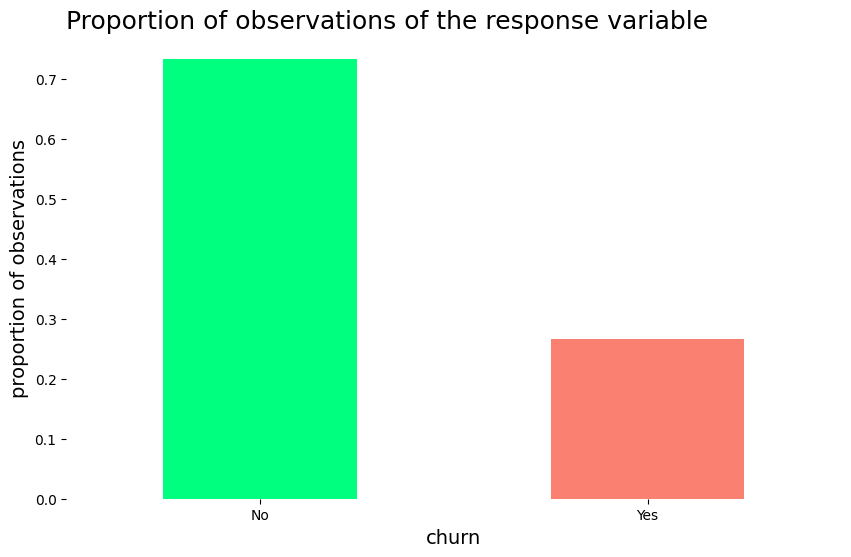

In [6]:
helpers.percent_stacked_plot_overall(df['Churn'])

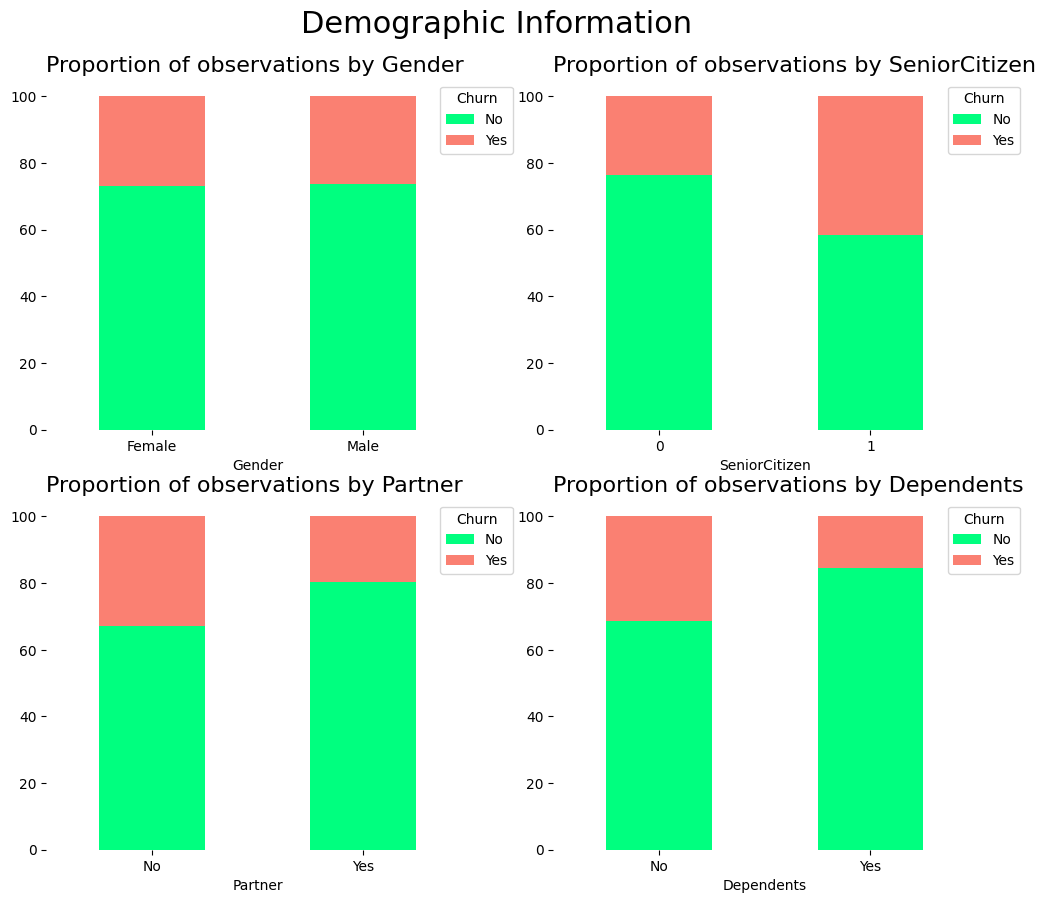

In [7]:
# demographic column names
demographic_columns = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
helpers.percentage_stacked_plot(df, 'Churn', demographic_columns, 'Demographic Information')

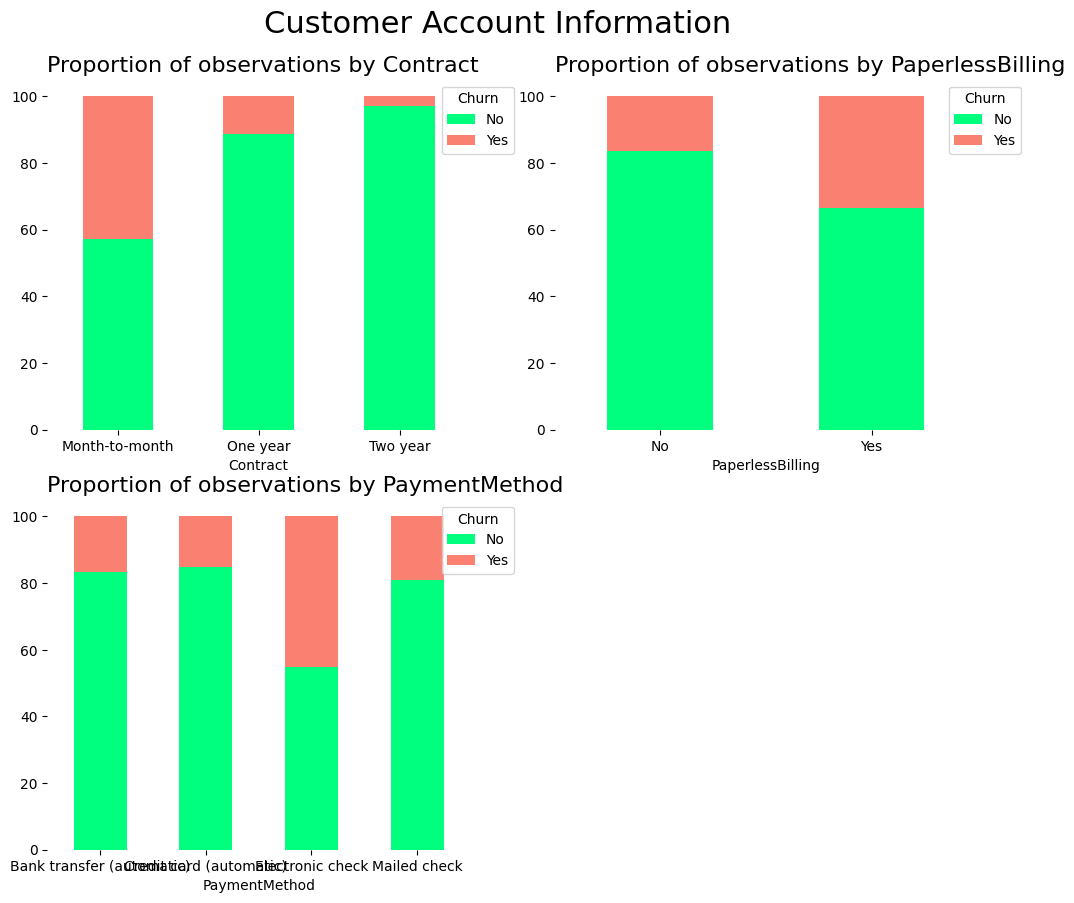

In [8]:
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
helpers.percentage_stacked_plot(df, 'Churn', account_columns, 'Customer Account Information')

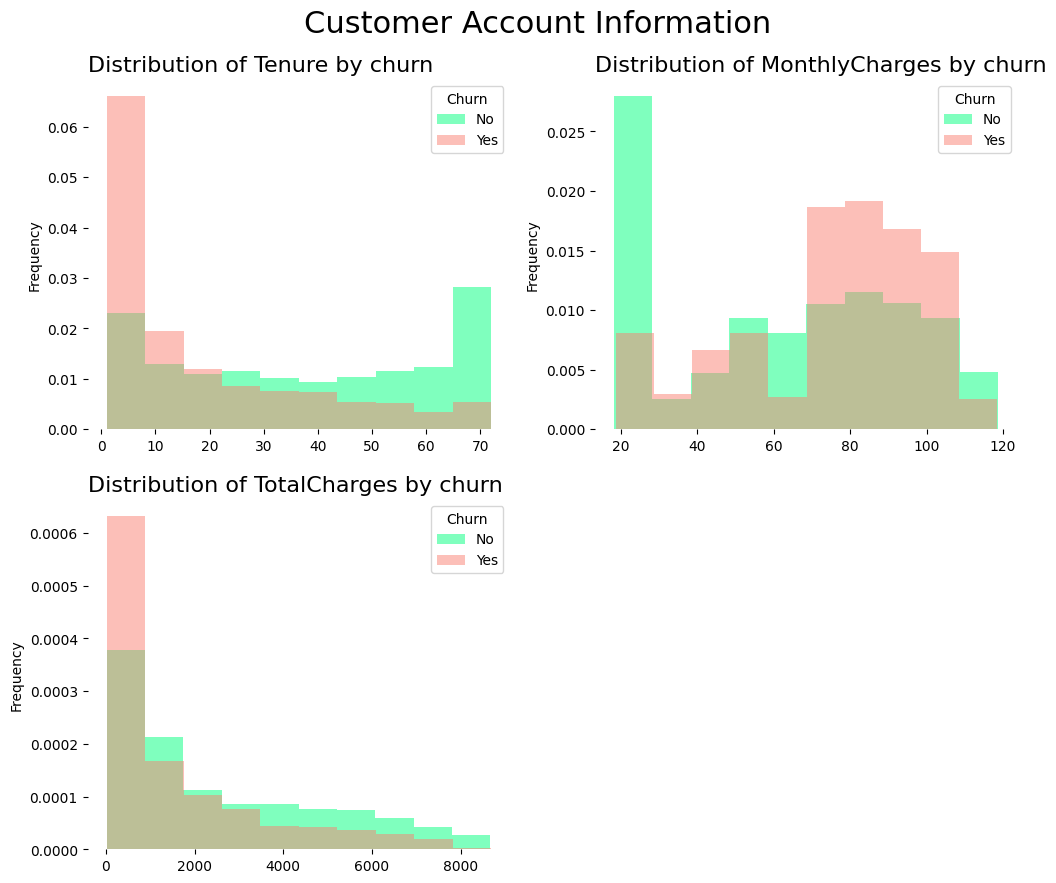

In [9]:
# customer account column names
account_columns_numeric = ['Tenure', 'MonthlyCharges', 'TotalCharges']

# histogram of costumer account columns 
helpers.histogram_plots(df, 'Churn', account_columns_numeric, 'Customer Account Information')

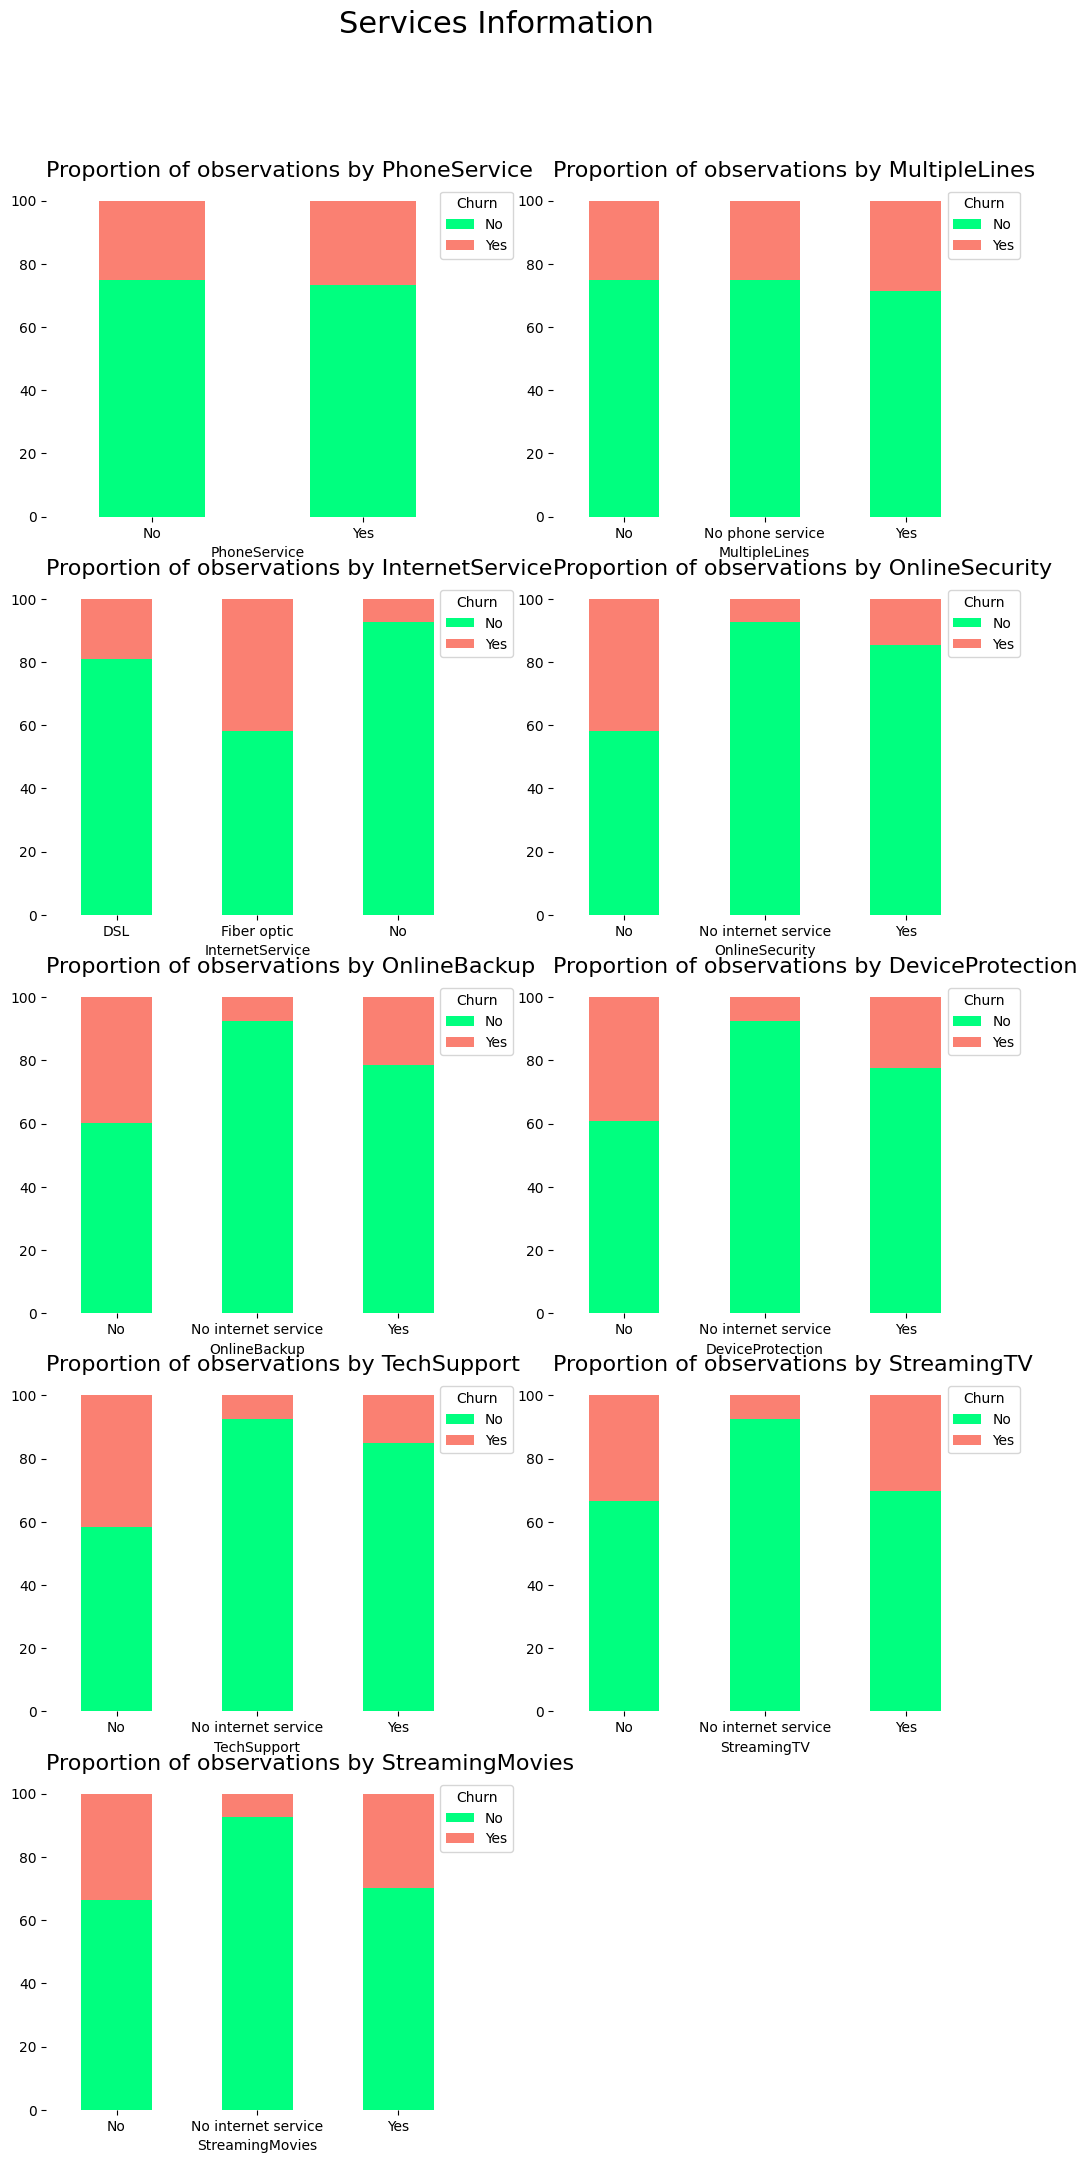

In [10]:
# services column names
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# stacked plot of services columns
helpers.percentage_stacked_plot(df, 'Churn', services_columns, 'Services Information')

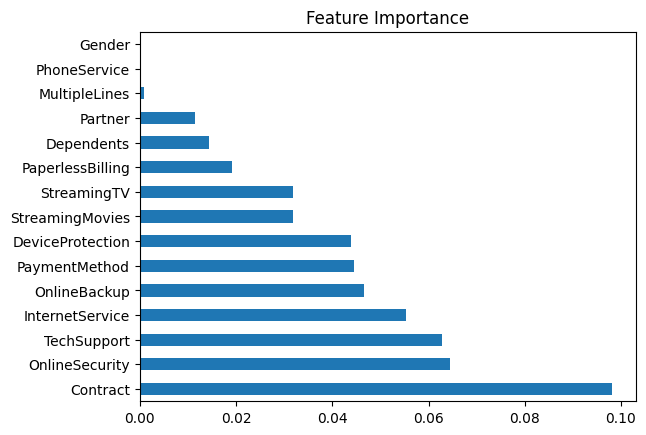

In [11]:
helpers.mutual_information_plot(df, 'Churn')

## Pre-processing

1. One-hot encode features
2. Scale numerical features
3. Drop useless/ highly correlated features
4. Impute any missing data
5. Train/ test split

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mutual_info_score, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
df_telco_transformed = df_telco.copy()

# label encoding (binary variables)
label_encoding_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']


# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']

# min-max normalization (numeric variables)
min_max_columns = ['Tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
X = df_telco_transformed.drop('Churn',axis=1)
y = 1 * (df_telco_transformed['Churn']== 'Yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
model = GradientBoostingClassifier()

In [ ]:
pipe = Pipeline(steps = 
    [('preprocessor', ColumnTransformer(
        transformers=
        [('numeric', 
          Pipeline(steps=[
              ('imputer', 'passthrough'), 
              ('scaler', MinMaxScaler())]),
          min_max_columns),
         
         ('categorical', 
          Pipeline(steps=[
              ('imputer', 'passthrough'), 
              ('encoder', OneHotEncoder())]), 
          one_hot_encoding_columns),
         
         ('binary', Pipeline(steps=[
             ('imputer', 'passthrough'),
             ('bin_encoder', OrdinalEncoder())]),
          label_encoding_columns)])),
    ('classify', model)
    ])

In [ ]:
log_model = pipe.fit(X_train, y_train)
print(log_model)

## Model Selection

In [ ]:
# define the parameter grid
param_grid = {'classify__n_estimators': [80, 90, 100, 110, 115, 120],
                   'classify__max_depth': [3, 4, 5, 6],
                   'classify__max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'classify__min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=pipe,
                                   param_distributions=param_grid,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)
#grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)

# fitting the model for random search 
random_search.fit(X_train, y_train)

# print best parameter after tuning
print(random_search.best_params_)

In [ ]:
# make the predictions
random_search_predictions = random_search.predict(X_test)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
confusion_matrix

In [ ]:
# print classification report 
print(classification_report(y_test, random_search_predictions))